In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import joblib

# optional, for progress bars
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wilcoxon


def get_bootstrap_aucs(y_true, y_pred, bootstrap_iters=100):
    rng = np.random.RandomState(seed=42)
    idxs = list(range(y_pred.shape[0]))

    bootstrap_aucs = []
    for _ in range(bootstrap_iters):
        curr_idxs = rng.choice(idxs, size=len(idxs), replace=True)
        bootstrap_aucs.append(roc_auc_score(y_true[curr_idxs], y_pred[curr_idxs],
                                            multi_class='ovr', average='macro'))

    return np.median(bootstrap_aucs), bootstrap_aucs


def get_p_values(all_aucs):
    all_aucs = np.vstack(all_aucs)
    median_aucs = np.median(all_aucs, -1)
    second_best_idx, best_idx = median_aucs.argsort()[-2:]
    p_val = wilcoxon(all_aucs[best_idx], all_aucs[second_best_idx])[1]
    return p_val, (best_idx, second_best_idx)


def pval_to_str(p_val):
    if p_val < 0.0001:
        p_val = 'p<0.0001'
        p_val = '***'
    else:
        p_val = f'p={p_val:.4f}'
    return p_val


def darken_hex(hex_color, factor=0.5):
    # Ensure the factor is between 0 and 1
    factor = max(0, min(factor, 1))

    # Remove the hash symbol if present
    hex_color = hex_color.lstrip('#')

    # Convert hex to RGB
    rgb = tuple(int(hex_color[i:i + 2], 16) for i in (0, 2, 4))

    # Darken the RGB values by multiplying by the factor
    darkened_rgb = tuple(int(c * factor) for c in rgb)

    # Convert the RGB values back to hex
    darkened_hex = '#{:02x}{:02x}{:02x}'.format(*darkened_rgb)

    return darkened_hex


dftrain = pd.read_csv('/mnt/c/Users/Justin/Desktop/retina_imaging_datasets/ROP_dataset/dftrain.csv')
dftest = pd.read_csv('/mnt/c/Users/Justin/Desktop/retina_imaging_datasets/ROP_dataset/dftest.csv')
name_X_list = [
    ('RETFound-MEH', 
     '/home/justin/RETFound_MAE/ROP_Train_RETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/ROP_Test_RETFound_Feature_latent.npy'),
    ('DERETFound', 
     '/home/justin/RETFound_MAE/ROP_Train_DERETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/ROP_Test_DERETFound_Feature_latent.npy'),
    ('RETFound-Green', 
     'ROP_Train_X_ours.npy',
     'ROP_Test_X_ours.npy'),
]
models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green']
colors = ['#ff595e', '#ffca3a', '#8ac926']


In [2]:
def run_rop_exp(name_X_list, models, colors,
                figsize=(12, 4), dashed_line_offsets=(-2.75, 0.25), xtick_loc_scaling=1, title_size='large'):
    targets = ['Normal', 'laser_scars', 'ROP',
               'Stage_1_ROP', 'Stage_2_ROP', 'Stage_3_ROP',
               'FINE_Stage_1_ROP', 'FINE_Stage_2_ROP', 'FINE_Stage_3_ROP',
              ]

    results_df = pd.DataFrame(columns=['Name'] + targets)
    name_bootstrap_aucs_dict = {}
    name_times_dict = {}
    for name, X_train_fname, X_test_fname in tqdm(name_X_list):
        np.random.seed(42)

        name_times_dict[name] = []
        median_aucs = []

        X_train = np.load(X_train_fname)
        X_test = np.load(X_test_fname)

        perf_str = f'{name:>20}:'
        for target_col in tqdm(targets, leave=True):
            y_train = dftrain['class'].apply(lambda x: x.endswith(target_col.replace("FINE_", ""))).values
            y_test = dftest['class'].apply(lambda x: x.endswith(target_col.replace("FINE_", ""))).values

            if target_col.startswith('FINE_'):
                # remove laser scars
                train_rop_mask = dftrain['class'].apply(lambda x: not x.endswith('laser_scars'))
                test_rop_mask = dftest['class'].apply(lambda x: not x.endswith('laser_scars'))

                X_train_curr = X_train[train_rop_mask]
                y_train = y_train[train_rop_mask]
                
                X_test_curr = X_test[test_rop_mask]
                y_test = y_test[test_rop_mask]

            else:
                # no changes needed
                X_train_curr = X_train
                X_test_curr = X_test
            

            start = time.time()
            clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
            clf.fit(X_train_curr, y_train)
            preds = clf.predict_proba(X_test_curr)[:, 1]
            stop = time.time()
            delta = stop - start
            name_times_dict[name].append(delta)

            curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test, preds)
            name_bootstrap_aucs_dict[f'{name}-{target_col}'] = curr_bootstrap_aucs
            median_aucs.append(curr_median_auc)

        perf_str += '\t'.join([f'{c}:{v:.4f}' for c, v in zip(targets, median_aucs)])
        print(perf_str)
        print(f'Total time: {sum(name_times_dict[name]):.4f}s / mean time: {np.mean(name_times_dict[name]):.4f}s')

        results_df.loc[name] = [name] + median_aucs

    display(results_df.round(4))

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    axes = axes.flat

    width = 0.25

    target_groups = {
        'Primary classification': ['Normal', 'laser_scars', 'ROP'],
        'Specific ROP stage vs everything else': ['Stage_1_ROP', 'Stage_2_ROP', 'Stage_3_ROP'],
        'Specific ROP stage - no laser scars': ['FINE_Stage_1_ROP', 'FINE_Stage_2_ROP', 'FINE_Stage_3_ROP'],
    }

    wins = {_: 0 for _ in models}
    ties = {_: 0 for _ in models}

    for target_group, ax in zip(target_groups, axes):
        targets = target_groups[target_group]
        x = np.arange(len(targets))

        for i, model in enumerate(models):
            values = [results_df.loc[model, target] for target in targets]
            locs = x + i * width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] + dashed_line_offsets[0] * width
                    _right = locs[_idx] + dashed_line_offsets[1] * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [name_bootstrap_aucs_dict[f'{name}-{target}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()

            if p_val < 0.05:
                wins[models[best_idx]] += 1
            else:
                ties[models[best_idx]] += 1
                ties[models[second_best_idx]] += 1

            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val + 0.001, best_val + 0.012, best_val + 0.012, best_val + 0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val < 0.0001 else 0.01
            ax.text((start_loc + end_loc) / 2, best_val + text_loc_height_offset, pval_to_str(p_val), ha='center',
                    fontsize='x-small',
                    weight=None if not p_val < 0.05 else 'bold')

            ax.set_xticks(x + width * xtick_loc_scaling)
            targets_display = [_.replace('_', ' ').title() for _ in targets]
            targets_display = [_.replace('Rop', "ROP").replace('Fine ', '').replace(' ROP', '')
                               for _ in targets_display]
            ax.set_xticklabels(targets_display, rotation=0, ha='center')
            ax.set_ylim(0.5, 1.03)
            ax.set_title(target_group, fontsize=title_size)

    axes[0].set_ylabel('AUC on test set')
    axes[1].set_yticklabels([])
    axes[2].set_yticklabels([])
    plt.tight_layout()
    plt.show()

    print('Statistically significant wins: ', wins)
    print('Ties for first place: ', ties)



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

        RETFound-MEH:Normal:0.9952	laser_scars:0.9991	ROP:0.9818	Stage_1_ROP:0.8296	Stage_2_ROP:0.7886	Stage_3_ROP:0.8634	FINE_Stage_1_ROP:0.8085	FINE_Stage_2_ROP:0.7076	FINE_Stage_3_ROP:0.7990
Total time: 0.4424s / mean time: 0.0492s


  0%|          | 0/9 [00:00<?, ?it/s]

          DERETFound:Normal:0.9949	laser_scars:0.9998	ROP:0.9920	Stage_1_ROP:0.8752	Stage_2_ROP:0.8879	Stage_3_ROP:0.9445	FINE_Stage_1_ROP:0.8261	FINE_Stage_2_ROP:0.8288	FINE_Stage_3_ROP:0.9311
Total time: 0.4433s / mean time: 0.0493s


  0%|          | 0/9 [00:00<?, ?it/s]

      RETFound-Green:Normal:0.9978	laser_scars:1.0000	ROP:0.9942	Stage_1_ROP:0.8915	Stage_2_ROP:0.8920	Stage_3_ROP:0.9699	FINE_Stage_1_ROP:0.8491	FINE_Stage_2_ROP:0.8359	FINE_Stage_3_ROP:0.9555
Total time: 0.7377s / mean time: 0.0820s


,Name,Normal,laser_scars,ROP,Stage_1_ROP,Stage_2_ROP,Stage_3_ROP,FINE_Stage_1_ROP,FINE_Stage_2_ROP,FINE_Stage_3_ROP
RETFound-MEH,RETFound-MEH,0.9952,0.9991,0.9818,0.8296,0.7886,0.8634,0.8085,0.7076,0.7990
DERETFound,DERETFound,0.9949,0.9998,0.9920,0.8752,0.8879,0.9445,0.8261,0.8288,0.9311
RETFound-Green,RETFound-Green,0.9978,1.0000,0.9942,0.8915,0.8920,0.9699,0.8491,0.8359,0.9555


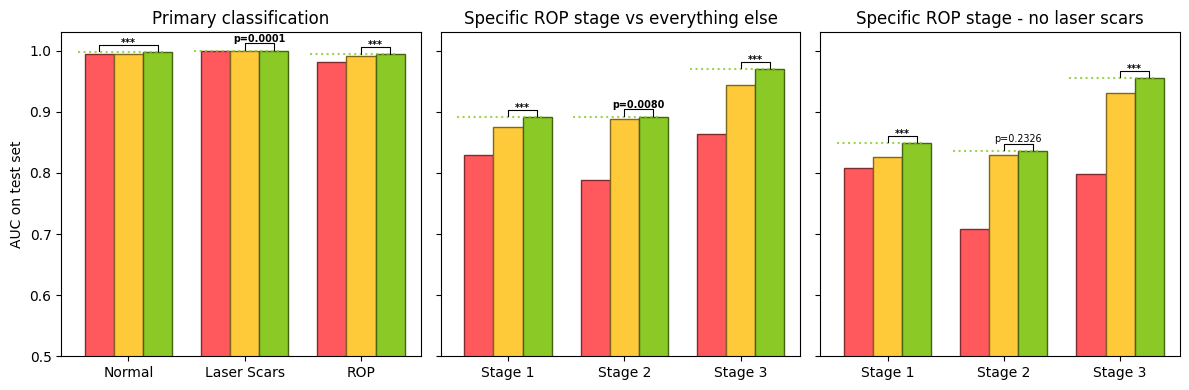

Statistically significant wins:  {'RETFound-MEH': 0, 'DERETFound': 0, 'RETFound-Green': 8}
Ties for first place:  {'RETFound-MEH': 0, 'DERETFound': 1, 'RETFound-Green': 1}


In [3]:
run_rop_exp(name_X_list, models, colors)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

      RETFound-Green:Normal:0.9978	laser_scars:1.0000	ROP:0.9942	Stage_1_ROP:0.8915	Stage_2_ROP:0.8920	Stage_3_ROP:0.9699	FINE_Stage_1_ROP:0.8491	FINE_Stage_2_ROP:0.8359	FINE_Stage_3_ROP:0.9555
Total time: 0.4900s / mean time: 0.0544s


  0%|          | 0/9 [00:00<?, ?it/s]

              DinoV2:Normal:0.9957	laser_scars:0.9997	ROP:0.9914	Stage_1_ROP:0.8678	Stage_2_ROP:0.9001	Stage_3_ROP:0.9663	FINE_Stage_1_ROP:0.8120	FINE_Stage_2_ROP:0.8440	FINE_Stage_3_ROP:0.9618
Total time: 0.9440s / mean time: 0.1049s


,Name,Normal,laser_scars,ROP,Stage_1_ROP,Stage_2_ROP,Stage_3_ROP,FINE_Stage_1_ROP,FINE_Stage_2_ROP,FINE_Stage_3_ROP
RETFound-Green,RETFound-Green,0.9978,1.0000,0.9942,0.8915,0.8920,0.9699,0.8491,0.8359,0.9555
DinoV2,DinoV2,0.9957,0.9997,0.9914,0.8678,0.9001,0.9663,0.8120,0.8440,0.9618


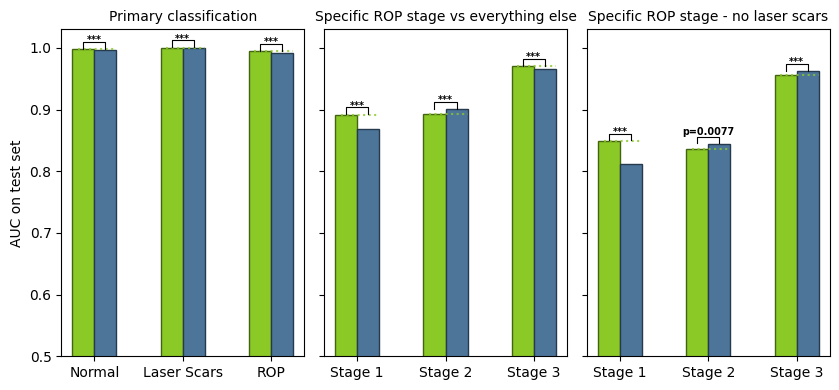

Statistically significant wins:  {'RETFound-Green': 6, 'DinoV2': 3}
Ties for first place:  {'RETFound-Green': 0, 'DinoV2': 0}


In [4]:
name_X_list = [
    ('RETFound-Green', 
     'ROP_Train_X_ours.npy',
     'ROP_Test_X_ours.npy'),
    ('DinoV2', 
     'ROP_Train_X_dino392.npy',
     'ROP_Test_X_dino392.npy'),
]

models = ['RETFound-Green', 'DinoV2']
colors = ['#8ac926', '#4d759a']

run_rop_exp(name_X_list, models, colors,
            figsize=(8.5, 4), dashed_line_offsets=(-0.25, 1.5), xtick_loc_scaling=0.5, title_size='medium')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

        RETFound-MEH:Normal:0.9952	laser_scars:0.9991	ROP:0.9818	Stage_1_ROP:0.8296	Stage_2_ROP:0.7886	Stage_3_ROP:0.8634	FINE_Stage_1_ROP:0.8085	FINE_Stage_2_ROP:0.7076	FINE_Stage_3_ROP:0.7990
Total time: 0.4725s / mean time: 0.0525s


  0%|          | 0/9 [00:00<?, ?it/s]

          DERETFound:Normal:0.9949	laser_scars:0.9998	ROP:0.9920	Stage_1_ROP:0.8752	Stage_2_ROP:0.8879	Stage_3_ROP:0.9445	FINE_Stage_1_ROP:0.8261	FINE_Stage_2_ROP:0.8288	FINE_Stage_3_ROP:0.9311
Total time: 0.6789s / mean time: 0.0754s


  0%|          | 0/9 [00:00<?, ?it/s]

  RETFound-Green@224:Normal:0.9977	laser_scars:0.9998	ROP:0.9906	Stage_1_ROP:0.9072	Stage_2_ROP:0.9245	Stage_3_ROP:0.9713	FINE_Stage_1_ROP:0.8639	FINE_Stage_2_ROP:0.8858	FINE_Stage_3_ROP:0.9670
Total time: 0.2830s / mean time: 0.0314s


,Name,Normal,laser_scars,ROP,Stage_1_ROP,Stage_2_ROP,Stage_3_ROP,FINE_Stage_1_ROP,FINE_Stage_2_ROP,FINE_Stage_3_ROP
RETFound-MEH,RETFound-MEH,0.9952,0.9991,0.9818,0.8296,0.7886,0.8634,0.8085,0.7076,0.7990
DERETFound,DERETFound,0.9949,0.9998,0.9920,0.8752,0.8879,0.9445,0.8261,0.8288,0.9311
RETFound-Green@224,RETFound-Green@224,0.9977,0.9998,0.9906,0.9072,0.9245,0.9713,0.8639,0.8858,0.9670


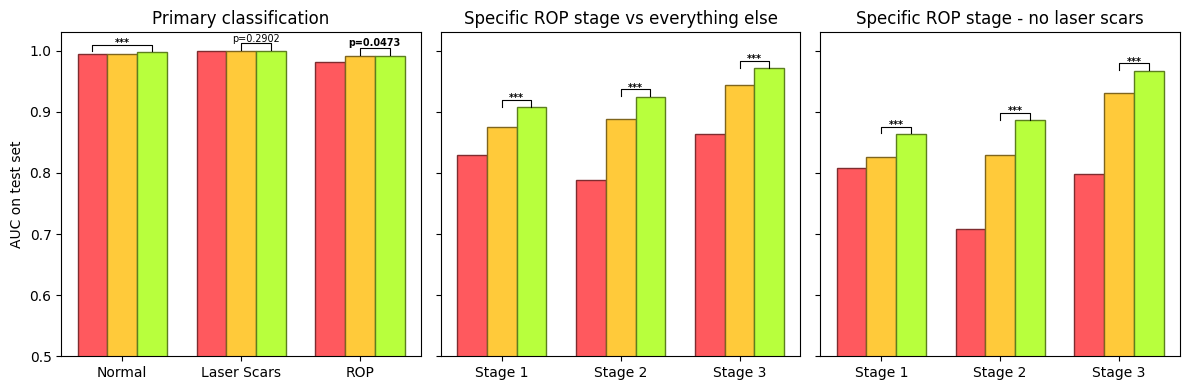

Statistically significant wins:  {'RETFound-MEH': 0, 'DERETFound': 1, 'RETFound-Green@224': 7}
Ties for first place:  {'RETFound-MEH': 0, 'DERETFound': 1, 'RETFound-Green@224': 1}


In [5]:
name_X_list = [
    ('RETFound-MEH', 
     '/home/justin/RETFound_MAE/ROP_Train_RETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/ROP_Test_RETFound_Feature_latent.npy'),
    ('DERETFound', 
     '/home/justin/RETFound_MAE/ROP_Train_DERETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/ROP_Test_DERETFound_Feature_latent.npy'),
    ('RETFound-Green@224', 
     'ROP_Train_X_ours224.npy',
     'ROP_Test_X_ours224.npy'),
]
models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green@224']
colors = ['#ff595e', '#ffca3a', '#B8FF3D']

run_rop_exp(name_X_list, models, colors)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  RETFound-Green@224:Normal:0.9977	laser_scars:0.9998	ROP:0.9906	Stage_1_ROP:0.9072	Stage_2_ROP:0.9245	Stage_3_ROP:0.9713	FINE_Stage_1_ROP:0.8639	FINE_Stage_2_ROP:0.8858	FINE_Stage_3_ROP:0.9670
Total time: 0.3062s / mean time: 0.0340s


  0%|          | 0/9 [00:00<?, ?it/s]

          DinoV2@224:Normal:0.9952	laser_scars:0.9995	ROP:0.9942	Stage_1_ROP:0.8740	Stage_2_ROP:0.9021	Stage_3_ROP:0.9801	FINE_Stage_1_ROP:0.8266	FINE_Stage_2_ROP:0.8605	FINE_Stage_3_ROP:0.9645
Total time: 0.4624s / mean time: 0.0514s


,Name,Normal,laser_scars,ROP,Stage_1_ROP,Stage_2_ROP,Stage_3_ROP,FINE_Stage_1_ROP,FINE_Stage_2_ROP,FINE_Stage_3_ROP
RETFound-Green@224,RETFound-Green@224,0.9977,0.9998,0.9906,0.9072,0.9245,0.9713,0.8639,0.8858,0.9670
DinoV2@224,DinoV2@224,0.9952,0.9995,0.9942,0.8740,0.9021,0.9801,0.8266,0.8605,0.9645


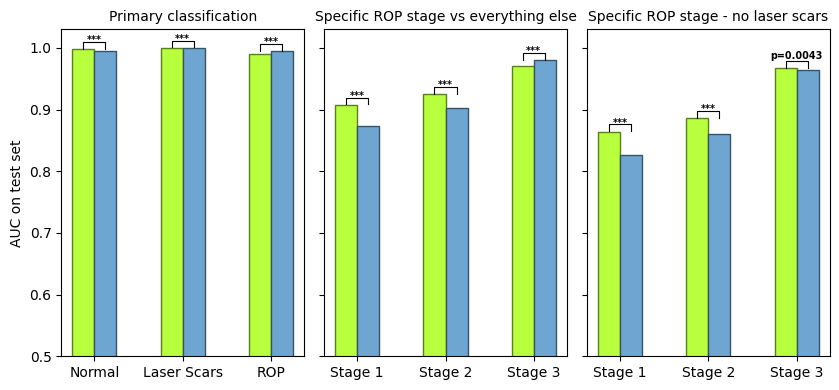

Statistically significant wins:  {'RETFound-Green@224': 7, 'DinoV2@224': 2}
Ties for first place:  {'RETFound-Green@224': 0, 'DinoV2@224': 0}


In [6]:
name_X_list = [
    ('RETFound-Green@224', 
     'ROP_Train_X_ours224.npy',
     'ROP_Test_X_ours224.npy'),
    ('DinoV2@224', 
     'ROP_Train_X_dino224.npy',
     'ROP_Test_X_dino224.npy'),
]

models = ['RETFound-Green@224', 'DinoV2@224']
colors = ['#B8FF3D', '#6EA6D1']

run_rop_exp(name_X_list, models, colors,
            figsize=(8.5, 4), dashed_line_offsets=(-0.25, 1.5), xtick_loc_scaling=0.5, title_size='medium')

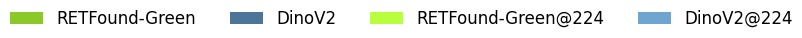

In [7]:
fig, ax = plt.subplots(figsize=(6, 0.2))
ax.axis('off')
models = ['RETFound-Green', 'DinoV2'] + ['RETFound-Green@224', 'DinoV2@224']
colors = ['#8ac926', '#4d759a'] + ['#B8FF3D', '#6EA6D1']
for model, color in zip(models, colors):
    ax.bar(0, 0, color=color, label=model)

legend = ax.legend(loc='center', ncol=4, frameon=False, fontsize=12,borderpad =0)

plt.show()